# Developing LLM agents

In [ ]:
%%capture
!pip install -q condacolab
import condacolab
condacolab.install() #get conda for colab

In [ ]:
%%capture
!git clone https://github.com/andrea-gariboldi/agents_seminar #clone seminar repository

import sys
!{sys.executable} -m pip install -q pydantic-ai==1.7.0 pandas==2.3.1 scikit-learn==1.7.1 #install necessary packages

sys.path.append('/content/agents_seminar') #add repo to path for main script

!conda env create -f /content/agents_seminar/env.yaml #create conda env for the agent

!curl -fsSL https://ollama.com/install.sh | sh #install Ollama

!nohup ollama serve > ollama.log 2>&1 &
!sleep 5 #start Ollama and make it listen

!ollama pull gpt-oss:20b #pull llm model

import os
os.chdir('/content/agents_seminar') #set current working dir inside the repository

## What's in this notebook?

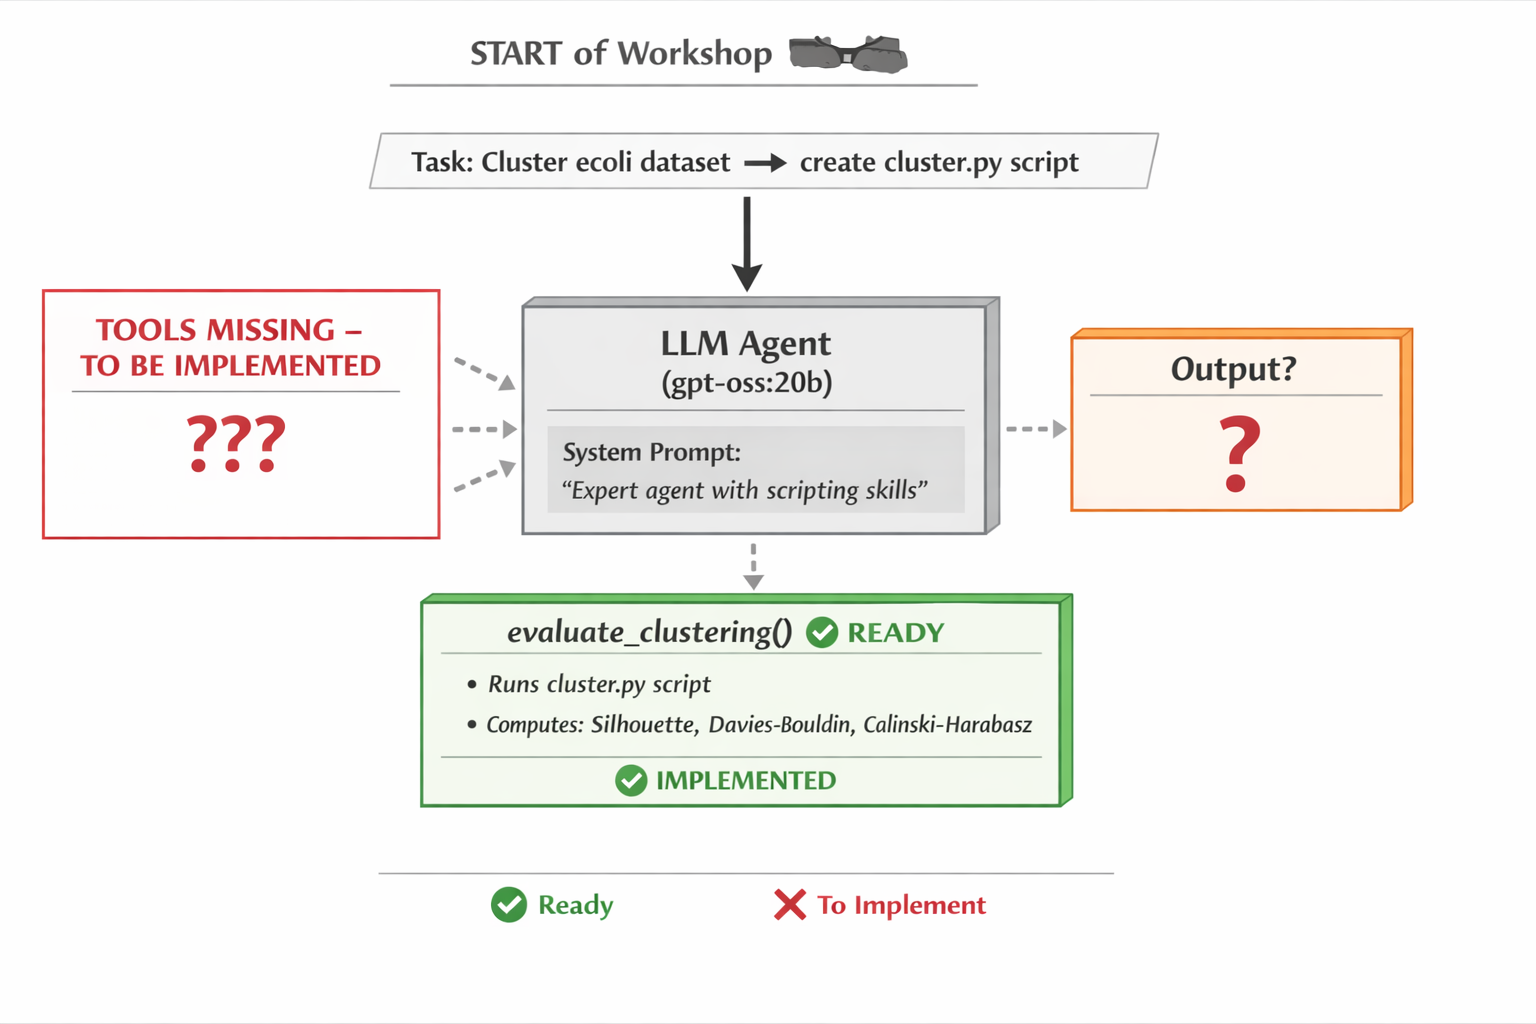

In [8]:
from IPython.display import Image
Image('res/workshop_start.png')

In [ ]:
from pydantic_ai import Agent
import os

from pydantic_ai.models.openai import OpenAIChatModel
from pydantic_ai.providers.ollama import OllamaProvider

from utils.agent_utils import run_agent
from utils.workspace_utils import cleanup_workspace
from eval.evaluate_result import evaluate_clustering

workspace_dir = f"{os.getcwd()}/agents_workspace/" # define where the agent will work

cleanup_workspace(workspace_dir=workspace_dir) # delete files produced by previous runs

ollama_model = OpenAIChatModel( # LLM model definition, will be used by the agent
    model_name='gpt-oss:20b', # model downloaded locally with Ollama in previous cell
    provider=OllamaProvider(base_url='http://localhost:11434/v1'), # define wheere Ollama is listening
)

agent = Agent( # define the agent
    model=ollama_model,
    system_prompt="You are an expert agent with scripting skills. Use the tools available to answer the user's requests."
) # system prompt guides the agent behavior

user_prompt = f"""Your final deliverable is to cluster a dataset. The original dataset is in the directory: {workspace_dir}data/. Take decisions on how to cluster based on the data provided.
            You should provide a python script that takes two commnad line arguments: --input for the input dataset path and --output for the output submission file path.
            The script should read the dataset from the input path, perform clustering, and save a submission file that contains the original columns,
            plus a new column 'cluster_id' indicating the cluster assignment for each row.
            Save the script as cluster.py in the current working directory ({workspace_dir}).
            """
#user prompt defines the tasks and the deliverables expected from the agent

async def main():
    await run_agent( #this runs the agent loop
        agent = agent,
        user_prompt=user_prompt,
        max_steps=10 # max 10 agent steps/actions - prevent infinite loops
    )

    # at this point, the agent has finished its run and we need to evaluate the produced clustering script
    evaluate_clustering(script_path=f"{os.getcwd()}/agents_workspace/cluster.py") #fixed programmatic evaluation after agent run

await main()